<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span></li><li><span><a href="#Loading" data-toc-modified-id="Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading</a></span></li><li><span><a href="#Initial-data" data-toc-modified-id="Initial-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial data</a></span></li><li><span><a href="#Second-data-(more-complete)" data-toc-modified-id="Second-data-(more-complete)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Second data (more complete)</a></span></li></ul></div>

# Notes

Analyzing data from Shuyuan, and understanding what it means and how it is distributed. 

# Loading

In [1]:
import numpy as np

import pandas as pd

In [2]:
import os

In [3]:
from itertools import product

In [4]:
import matplotlib.pyplot as plt

In [5]:
os.listdir("data/")

['Parameters_for_Lucas_CDK4KTR.csv',
 'mChHDHB.xlsx',
 'Parameters_for_Lucas_mChGem.csv',
 'mChGem.xlsx',
 'Parameters_for_Lucas_mChHDHB.csv',
 'CDK4KTR.xlsx']

# Initial data 

In [6]:
dfs_ = dict()
for fnm in os.listdir("data/"):
    if fnm.endswith('xlsx'):
        continue
    nm = fnm.split('.')[-2].split("_")[-1]
    df = pd.read_csv(os.path.join("data/", fnm), index_col=0)
    dfs_[nm] = df

In [7]:
def plot_data(df, G1_th=10):
    
    _, ax = plt.subplots(3, 3, figsize=(15, 10))
    
    for i, j in product(range(3), range(3)):
        
        k = 3*i + j 
        
        if k >= len(df.columns):
            return
        
        col = df.columns[k]
        
        idx_G1 = df.index[df.G1_length>G1_th]
        color = "dodgerblue"
        ax[i,j].hist(df.loc[idx_G1, col], density=True, alpha=.5, color=color)
        ax[i,j].axvline(df.loc[idx_G1, col].mean(), label="mean G1+", color=color)
        ax[i,j].axvline(df.loc[idx_G1, col].median(), linestyle="--", label="median G1+", color=color)
        
        idx_G1 = df.index[df.G1_length<=G1_th]
        color = "darkorange"
        ax[i,j].hist(df.loc[idx_G1, col], density=True, alpha=.5, color=color)
        ax[i,j].axvline(df.loc[idx_G1, col].mean(), label="mean G1-", color=color)
        ax[i,j].axvline(df.loc[idx_G1, col].median(), linestyle="--", label="median G1-", color=color)
        ax[i,j].set_xlabel(col)
        ax[i,j].set_ylabel("Density")
        ax[i,j].grid()
        ax[i,j].legend()
        
    return

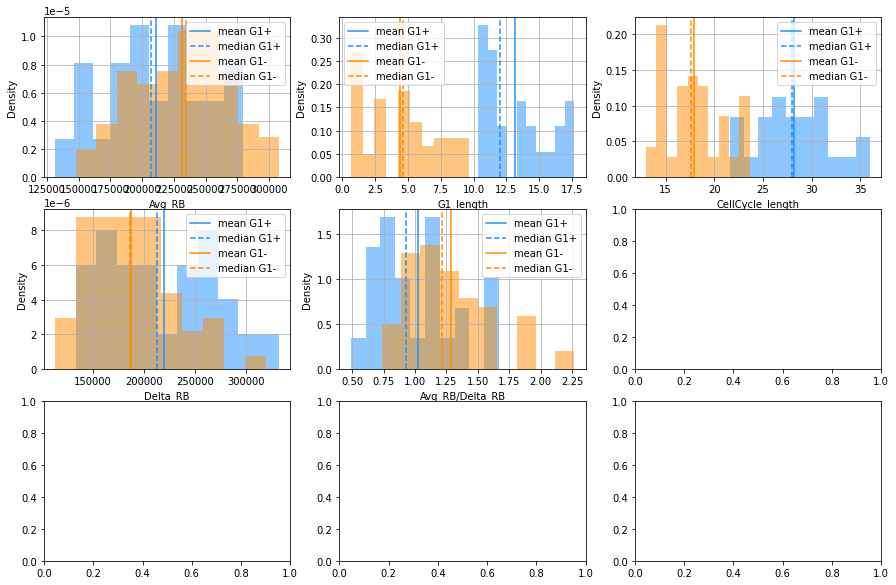

In [8]:
plot_data(dfs_["CDK4KTR"])

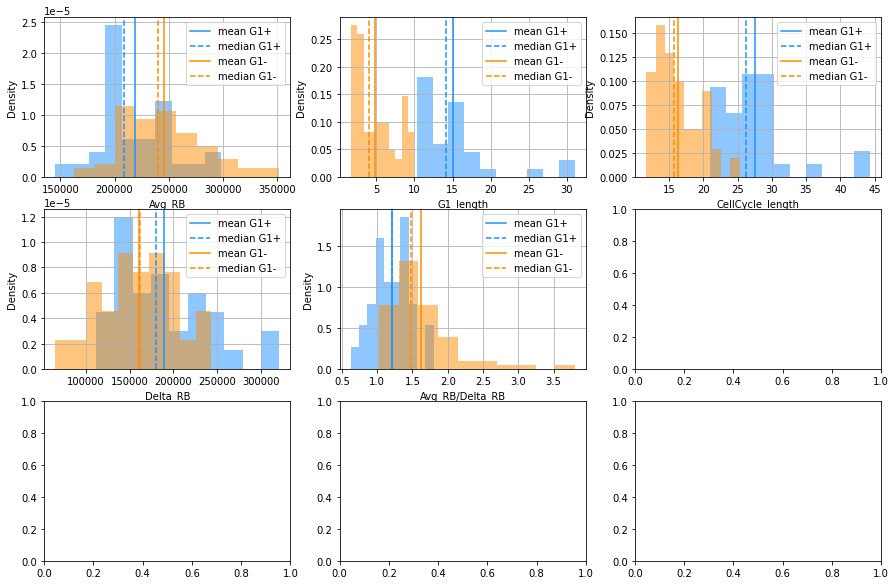

In [9]:
plot_data(dfs_["mChHDHB"])

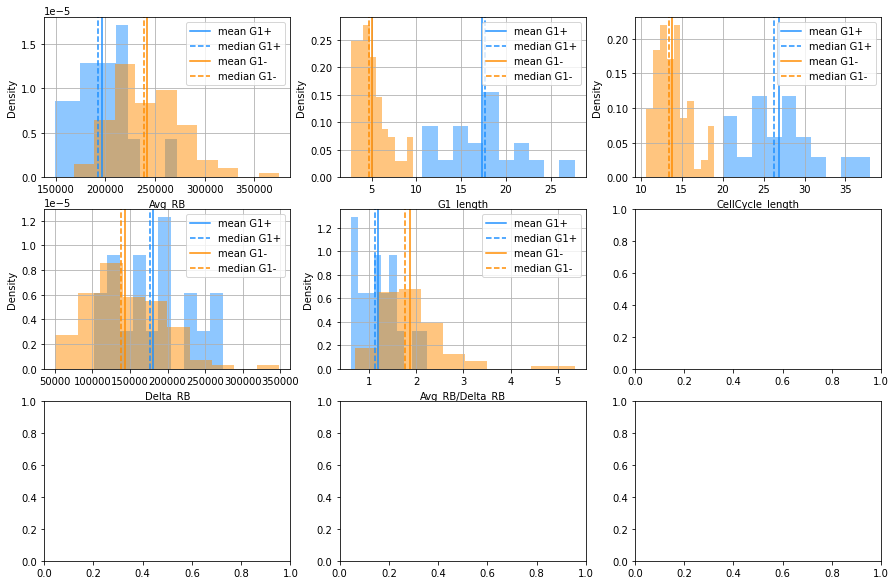

In [10]:
plot_data(dfs_["mChGem"])

From this data we can extract: 
- $\gamma$ (assuming that the growth is actually exponential)
- $\tau_{SG2}$
- extract a location in the plot where we are given the ratio of the amounts. Right? 


# Second data (more complete)

What we need/can add to the dataset. 
- how much do they grow in G1, G2

In [11]:
dfs = dict()
for fnm in os.listdir("data/"):
    if fnm.endswith("csv") or "$" in fnm:
        continue
    nm = fnm.split(".xlsx")[0]
    dfs[nm] = dict()
    
    sheets = ["Area", "Frame", "Clover"]
    for sh in sheets:
        dfs[nm][sh] = pd.read_excel(os.path.join("data/", fnm), index_col=0, sheet_name=sh)

In [12]:
# get the mass at transition
window_size = 5 # number of timepoints taken into the estimate of mass at transition
mass_transition = dict()

idx_transition = dict()
growth_G1 = dict()
growth_G2 = dict()

cc_length = dict()

RB_var = dict()

offset = int((window_size-1)/2)


for key_ in dfs: 
    
    df_crt = dfs[key_]
    
    # G1 length
    idx_transition[key_] = {
        cell_id: df_crt['Frame'].index[df_crt['Frame'][cell_id]==0][0] for cell_id in df_crt['Frame'].columns
    }
    
    
    # cell cycle length
    cc_length[key_] = {
    cell_id : df_crt["Frame"].index[df_crt["Frame"][cell_id].isna()][0] for cell_id in df_crt["Frame"].columns
    }
    
    # RB amount variation
    RB_var[key_] = {
        cell_id: (df_crt["Clover"][cell_id].max()-df_crt["Clover"][cell_id].min())/df_crt["Clover"][cell_id].mean()
        for cell_id in df_crt["Clover"].columns
    }
    
    
    # mass at transition
    mass_transition[key_] = dict()
    growth_G1[key_] = dict()
    growth_G2[key_] = dict()
    
    for cell_id in df_crt['Area'].columns:
        mass_transition_ = df_crt['Area'].loc[
            idx_transition[key_][cell_id]-offset:idx_transition[key_][cell_id]+offset, cell_id
        ].mean()
        mass_transition[key_][cell_id] = mass_transition_
        mass_init = df_crt['Area'].loc[1:4, cell_id].mean()
        mass_final = df_crt['Area'][cell_id].max()
        growth_G1[key_][cell_id] = mass_transition_/mass_init
        growth_G2[key_][cell_id] = mass_final/mass_transition_

In [13]:
df_params = dict()

for key_ in dfs:
    df_params[key_] = pd.DataFrame(columns = ["Area_transition", "G1_length", "Cycle_length", "Delta_RB/Avg_RB"])
    for cell_id in mass_transition[key_]:
        df_params[key_].loc[cell_id, "Area_transition"] = mass_transition[key_][cell_id]
        df_params[key_].loc[cell_id, "G1_growth"] = growth_G1[key_][cell_id]
        df_params[key_].loc[cell_id, "G2_growth"] = growth_G2[key_][cell_id]
        df_params[key_].loc[cell_id, "G1_length"] = idx_transition[key_][cell_id]/3
        df_params[key_].loc[cell_id, "Cycle_length"] = cc_length[key_][cell_id]/3
        df_params[key_].loc[cell_id, "Delta_RB/Avg_RB"] = RB_var[key_][cell_id]
    
    df_params[key_]["G2_length"] = df_params[key_]["Cycle_length"] - df_params[key_]["G1_length"]

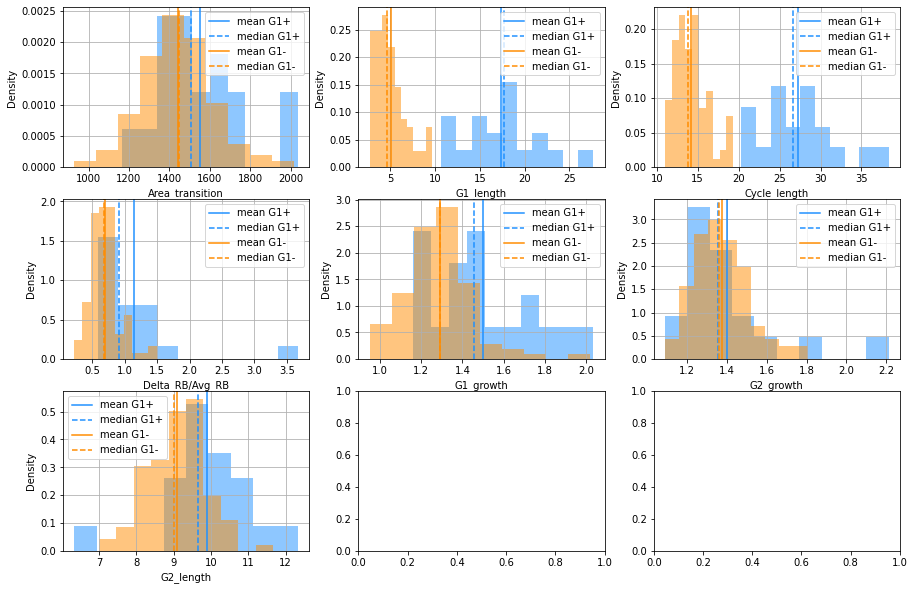

In [14]:
plot_data(df_params["mChGem"])

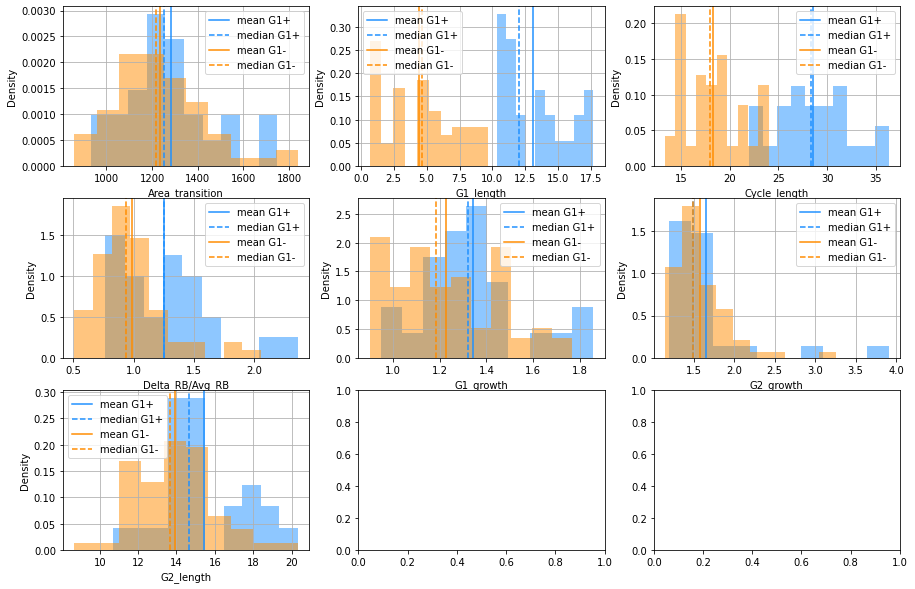

In [15]:
plot_data(df_params["CDK4KTR"])

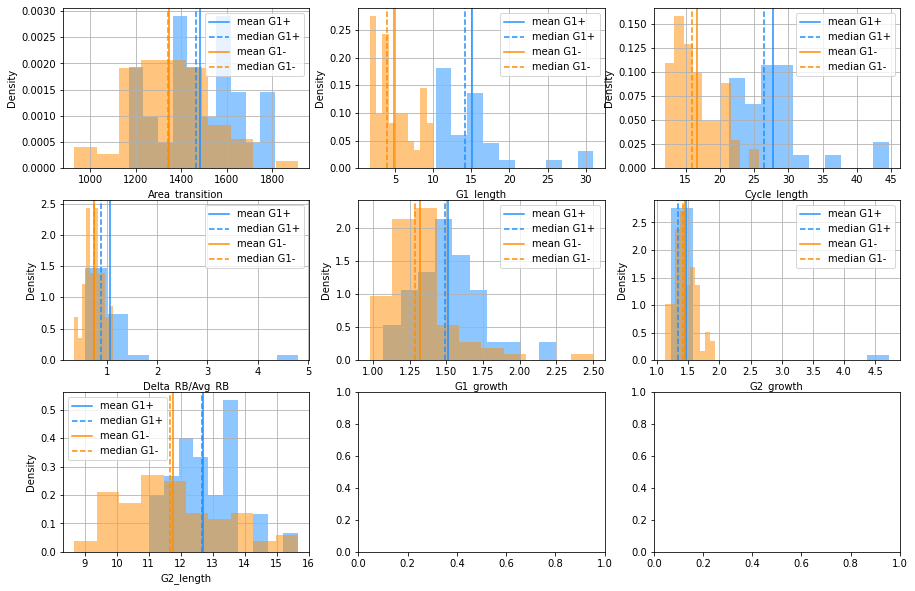

In [16]:
plot_data(df_params["mChHDHB"])